This Notebook aims to combine all necessary steps for each model of the nonlinear ML methods.

In [1]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.neural_network import MLPRegressor
from darts.metrics import mape, r2_score, mase, mse
import sklearn
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier
import copy
import tabulate

import warnings

In [2]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))
# get rid of the LinAlgWarning message
#from numpy.linalg import LinAlgWarning
#warnings.filterwarnings('ignore', category=LinAlgWarning)

In [3]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)

In [4]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()

Stored 'cum_returns' (DataFrame)


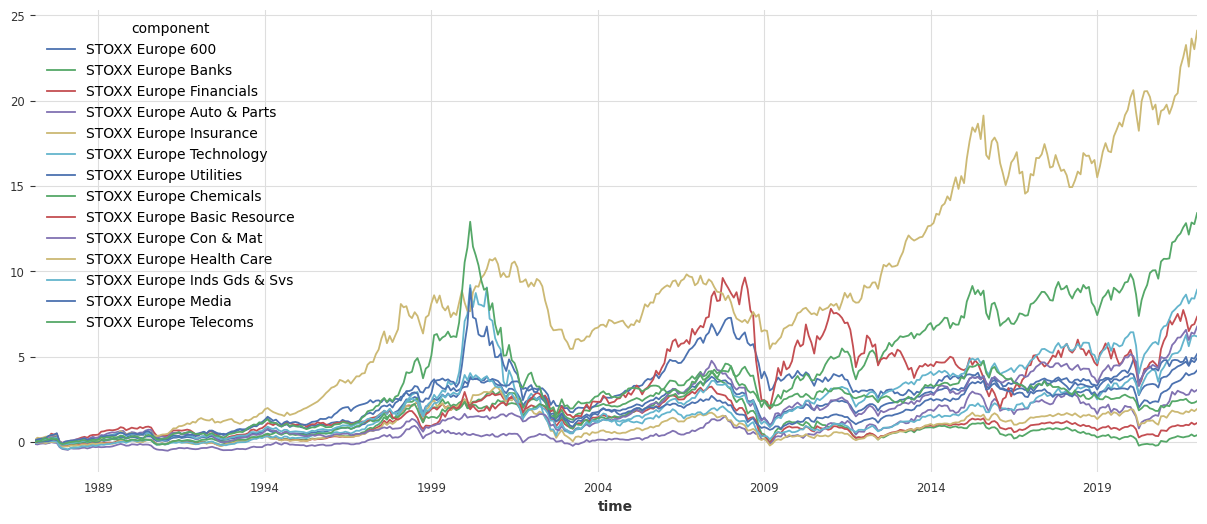

In [5]:
#from io import BytesIO
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns
# store the cum_returns to use it in another notebook
%store cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);

In [6]:
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

In [7]:
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

## Benchmark Portfolios

Our main benchmark is the STOXX Europe 600 Index. Furthermore, we expand the benchmarks by computing the equal weighted portfolio and portfolio based on historical averages.

### Equal Weighted Portfolio

In [8]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

# create weights
weights_ew = 1/len(col_list)

# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


### Portfolio based on Historical Average

In [9]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# show the last 5 rows of portfolio_returns of historical average portfolio
portfolio_returns.tail()

component,equal_weighted,historical_average
time,,
2021-09-01,6.334322,10.565259
2021-10-01,5.926514,9.912039
2021-11-01,6.322933,10.583310
2021-12-01,6.237121,10.402550
2022-01-01,6.544394,10.913366


In [10]:
# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
STOXX Europe Banks             0.033024
STOXX Europe Financials        0.030685
STOXX Europe Auto & Parts      0.021829
STOXX Europe Insurance         0.027747
STOXX Europe Technology        0.050778
STOXX Europe Utilities         0.085845
STOXX Europe Chemicals         0.108597
STOXX Europe Basic Resource    0.099537
STOXX Europe Con & Mat         0.061754
STOXX Europe Health Care       0.258600
STOXX Europe Inds Gds & Svs    0.076979
STOXX Europe Media             0.063096
STOXX Europe Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


In [11]:
def plot_efficient_frontier(mu, S, cum_returns_portfolio, title):
    ef = EfficientFrontier(mu, S)
    ef.add_constraint(lambda w: w[0] == 0.00)
    fig, ax = plt.subplots()
    ef_max_sharpe = ef.deepcopy()
    ef_min_vol = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the tangency portfolio with max Sharpe ratio
    ef_max_sharpe.max_sharpe()
    weights_max = ef_max_sharpe.clean_weights()
    ret_max = (cum_returns_portfolio * weights_max).sum(axis=1)
    std_max = ret_max.std()
    ax.scatter(std_max, ret_max.iloc[-1], marker="*", s=100, c="r", label="Max Sharpe")

    # Find the minimum volatility portfolio
    ef_min_vol.min_volatility()
    weights_min = ef_min_vol.clean_weights()
    ret_min = (cum_returns_portfolio * weights_min).sum(axis=1)
    std_min = ret_min.std()
    ax.scatter(std_min, ret_min.iloc[-1], marker="*", s=100, c="g", label="Min Volatility")    
    
    # compute the efficient frontier mathematically while using same optimization objective as the EfficientFrontier class without using pyportfolioopt
    """
    # Compute the efficient frontier
    """

    # save the return and volatility of max sharpe and min vola in two lists to a csv file naming them after mu

    
    
    # Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ S @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    weights_max = pd.DataFrame.from_dict(weights_max, orient='index')
    weights_max.columns = ['Max Sharpe']
    weights_max = weights_max.T
    weights_min = pd.DataFrame.from_dict(weights_min, orient='index')
    weights_min.columns = ['Min Volatility']
    weights_min = weights_min.T
    
    
    # Generate a table with the weights of the max Sharpe ratio portfolio
    weights = pd.concat([weights_max, weights_min])
    # drop the rows with 0 weights in both portfolios
    weights = weights.loc[:, (weights != 0).any(axis=0)]
    # add a column that sums the weights per row
    weights['Sum'] = weights.sum(axis=1)

    # Display the clean table
    print("Weights:\n", weights.to_string(index=True, float_format='{:.2%}'.format))

    # Display the return and volatility of the max Sharpe ratio and min volatility portfolios
    performance = pd.DataFrame({"Return": [ret_max.iloc[-1]/100, ret_min.iloc[-1]/100],
                                "Volatility": [std_max/100, std_min/100]},
                               index=["Max Sharpe", "Min Volatility"])

    # Display the performance table
    print("\nPerformance:\n", performance.to_string(float_format='{:.2%}'.format))

    # Print table as LaTeX
    #print("\nWeights (LaTeX):\n", weights.transpose().to_latex(index=True, float_format='{:.2%}'.format))
    #print("\nPerformance (LaTeX):\n", performance.transpose().to_latex(float_format='{:.2%}'.format))

    # Output
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show();

In [12]:
def generate_pie_chart(weights, title):
    cleaned_weights = {k: v for k, v in weights.items() if v > 1e-5}

    plt.figure(figsize=(10, 5))
    # Generate the pie chart without labels inside the slices
    wedges, _, _ = plt.pie(cleaned_weights.values(), labels=[''] * len(cleaned_weights), autopct='%1.2f%%', startangle=90)

    # Create a legend with the cleaned weights keys
    plt.legend(wedges, cleaned_weights.keys(), loc='upper left')

    # Create a legend with the cleaned weights keys
    plt.legend(wedges, cleaned_weights.keys(), loc='upper left')# Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis('equal')
    plt.title(title)
    plt.show();

## Nonlinear ML Methods

### Random Forest

In [13]:
"""hyperparameter_randomforest = {
    "lags": [1],
    'n_estimators': list(range(90, 150, 1)),
    'max_depth': [300],
    'random_state': [0]
}"""

'hyperparameter_randomforest = {\n    "lags": [1],\n    \'n_estimators\': list(range(90, 150, 1)),\n    \'max_depth\': [300],\n    \'random_state\': [0]\n}'

In [14]:
"""random_forest_tune = RandomForest(
    lags=hyperparameter_randomforest['lags'][0], 
   n_estimators=hyperparameter_randomforest['n_estimators'][0],
    max_depth=hyperparameter_randomforest['max_depth'][0],
    random_state = 0
    )"""

"random_forest_tune = RandomForest(\n    lags=hyperparameter_randomforest['lags'][0], \n   n_estimators=hyperparameter_randomforest['n_estimators'][0],\n    max_depth=hyperparameter_randomforest['max_depth'][0],\n    random_state = 0\n    )"

In [15]:
"""tuning_randomforest = random_forest_tune.gridsearch(
    parameters= hyperparameter_randomforest,
    series= train,
    val_series= test,
    start= 0.1,
    #metric= mse,
    n_jobs= -1,
    verbose= True
)"""

'tuning_randomforest = random_forest_tune.gridsearch(\n    parameters= hyperparameter_randomforest,\n    series= train,\n    val_series= test,\n    start= 0.1,\n    #metric= mse,\n    n_jobs= -1,\n    verbose= True\n)'

In [16]:
"""# print the best model parameters
best_model, best_params = tuning_randomforest[0], tuning_randomforest[1]
best_model.model_params"""

'# print the best model parameters\nbest_model, best_params = tuning_randomforest[0], tuning_randomforest[1]\nbest_model.model_params'

In [17]:
# random forest regression model with 1 lag
randomforest_model_1 = RegressionModel(lags=1, model=sklearn.ensemble.RandomForestRegressor(n_estimators=147, max_depth=300, random_state=0))
randomforest_model_1.fit(train)
randomforest_forecast_1 = randomforest_model_1.predict(len(test))

# random forest regression model with 316 lags
#randomforest_model_316 = RegressionModel(lags=316, model=sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=10000))
#randomforest_model_316.fit(train)
#randomforest_forecast_316 = randomforest_model_316.predict(len(test))

# random forest regression model with 317 lags
#randomforest_model_317 = RegressionModel(lags=317, model=sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=10))
#randomforest_model_317.fit(train)
#randomforest_forecast_317 = randomforest_model_317.predict(len(test))

# random forest regression model with 335 lags
#randomforest_model_335 = RegressionModel(lags=335, model=sklearn.ensemble.RandomForestRegressor(n_estimators=100, max_depth=1))
#randomforest_model_335.fit(train)
#randomforest_forecast_335 = randomforest_model_335.predict(len(test))

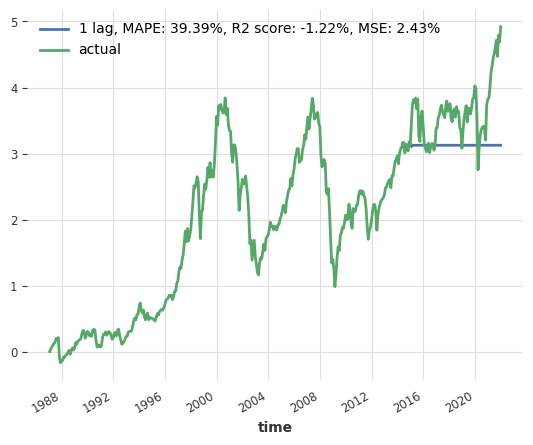

In [18]:
# plot the random forest forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
randomforest_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, randomforest_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_1), 2)) + '%')
#randomforest_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, randomforest_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_316), 2)) + '%')
#randomforest_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, randomforest_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_317), 2)) + '%')
#randomforest_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, randomforest_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, randomforest_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, randomforest_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [19]:
# first random forest model with 1 lag
hf1_random_forest = randomforest_model_1.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# second random forest model with 316 lags
#hf2_random_forest = randomforest_model_316.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# third random forest model with 317 lags
#hf3_random_forest = randomforest_model_317.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

# fourth random forest model with 335 lags
#hf4_random_forest = randomforest_model_335.historical_forecasts(series= cum_returns, start= 0.7, forecast_horizon= 1, verbose= True)

  0%|          | 0/127 [00:00<?, ?it/s]

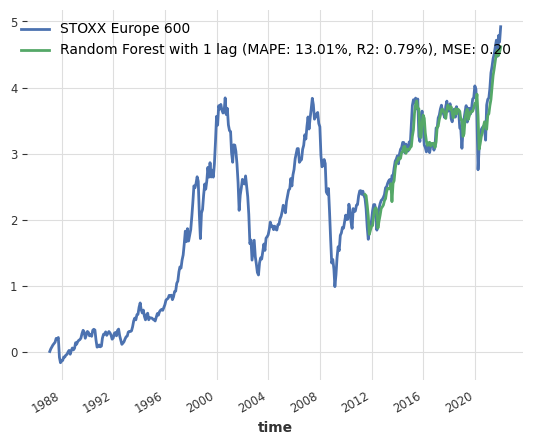

In [20]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_random_forest['STOXX Europe 600'].plot(label='Random Forest with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_random_forest, cum_returns), r2_score(hf1_random_forest, cum_returns), mse(hf1_random_forest, cum_returns)))
#hf2_random_forest['STOXX Europe 600'].plot(label='Random Forest with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf2_random_forest, cum_returns), r2_score(hf2_random_forest, cum_returns), mse(hf2_random_forest, cum_returns)))
#hf3_random_forest['STOXX Europe 600'].plot(label='Random Forest with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf3_random_forest, cum_returns), r2_score(hf3_random_forest, cum_returns), mse(hf3_random_forest, cum_returns)))
#hf4_random_forest['STOXX Europe 600'].plot(label='Random Forest with 335 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf4_random_forest, cum_returns), r2_score(hf4_random_forest, cum_returns), mse(hf4_random_forest, cum_returns)))

#### Portfolio

In [21]:
# change the type of the random forest forecast to a dataframe
randomforest_forecast_1 = randomforest_forecast_1.pd_dataframe()

In [22]:
# perform mean-variance optimization on the random forest forecast
mu_randomforest_1 = expected_returns.mean_historical_return(randomforest_forecast_1)
S_randomforest_1 = risk_models.sample_cov(randomforest_forecast_1)

In [23]:
# optimize for maximal Sharpe ratio
ef_randomforest_1 = EfficientFrontier(mu_randomforest_1, S_randomforest_1)
ef_randomforest_1.add_constraint(lambda w: w[0] == 0)
weights_randomforest_1 = ef_randomforest_1.max_sharpe(risk_free_rate=0.02)

In [24]:
# print weights
print(weights_randomforest_1)

OrderedDict([('STOXX Europe 600', -4.113028e-10), ('STOXX Europe Banks', 2.2598839262e-06), ('STOXX Europe Financials', 9.512880773e-07), ('STOXX Europe Auto & Parts', 3.016950891e-07), ('STOXX Europe Insurance', -1.06018872e-08), ('STOXX Europe Technology', 2.565379016e-07), ('STOXX Europe Utilities', -6.846501866e-07), ('STOXX Europe Chemicals', -1.1032681152e-06), ('STOXX Europe Basic Resource', -8.69882097e-08), ('STOXX Europe Con & Mat', -6.84006037e-08), ('STOXX Europe Health Care', 0.9999983928406648), ('STOXX Europe Inds Gds & Svs', -3.781554011e-07), ('STOXX Europe Media', 1.670298525e-07), ('STOXX Europe Telecoms', 2.9419944e-09)])


In [25]:
# compute the returns of the random forest portfolio
rf_returns_1 = (cum_returns_portfolio * weights_randomforest_1).sum(axis=1)

portfolio_returns['random_forest_1'] = rf_returns_1

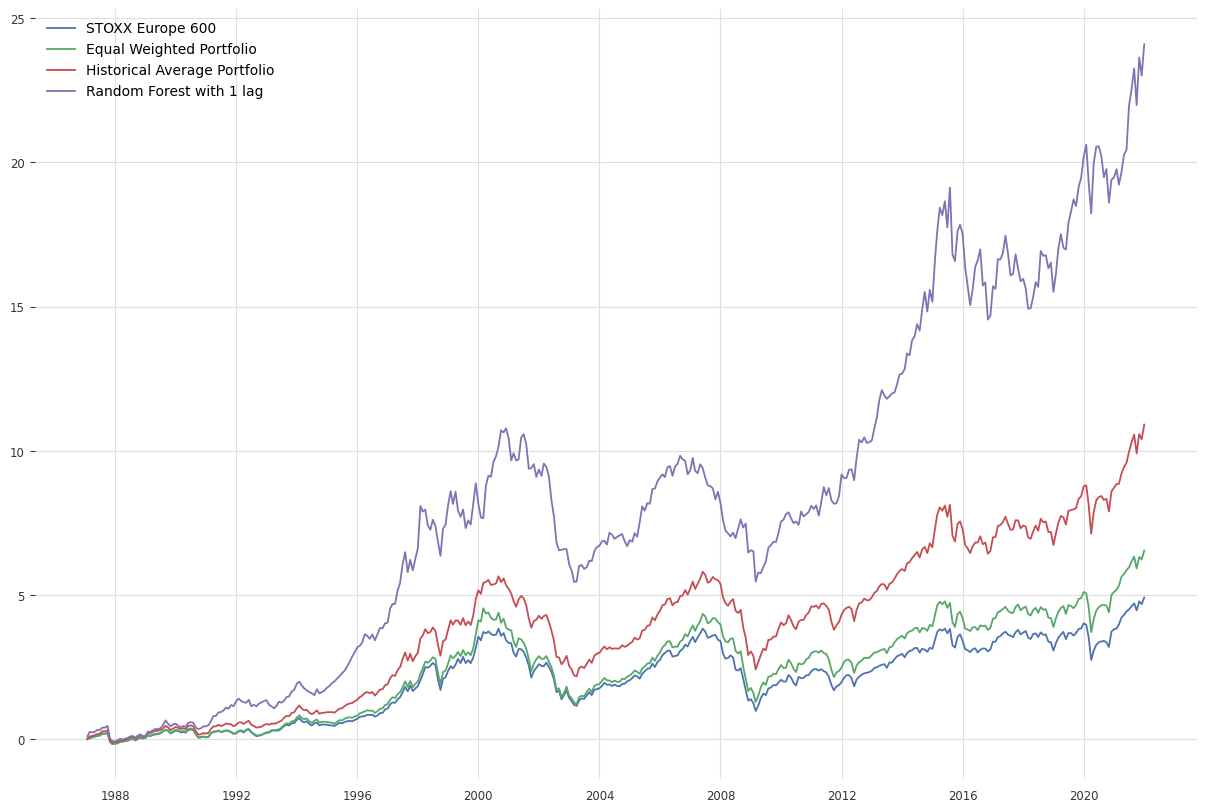

In [26]:
# plot the cumulative returns of the benchmark and the bridge regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['random_forest_1'], label='Random Forest with 1 lag')
plt.legend(loc='upper left')
plt.show();

In [27]:
# show the last value of each portfolio and round it to 2 decimals
print('Last value of the STOXX Europe 600: ' + str(np.round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('The last value of the equal weighted portfolio is: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('The last value of the historical average portfolio is: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('The last value of the random forest portfolio with 1 lag is: ' + str(round(portfolio_returns['random_forest_1'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
The last value of the equal weighted portfolio is: 6.54%
The last value of the historical average portfolio is: 10.91%
The last value of the random forest portfolio with 1 lag is: 24.1%


In [28]:
#compute the volatility of each portfolio
print('Volatility of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].std(), 2)) + '%')
print('Volatility of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].std(), 2)) + '%')
print('Volatility of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].std(), 2)) + '%')
print('Volatility of the linear regression portfolio with 1 lag: ' + str(round(portfolio_returns['random_forest_1'].std(), 2)) + '%')

Volatility of the STOXX Europe 600: 1.31%
Volatility of the equal weighted portfolio: 1.63%
Volatility of the historical average portfolio: 2.67%
Volatility of the linear regression portfolio with 1 lag: 6.03%


#### Plots Portfolio Analysis

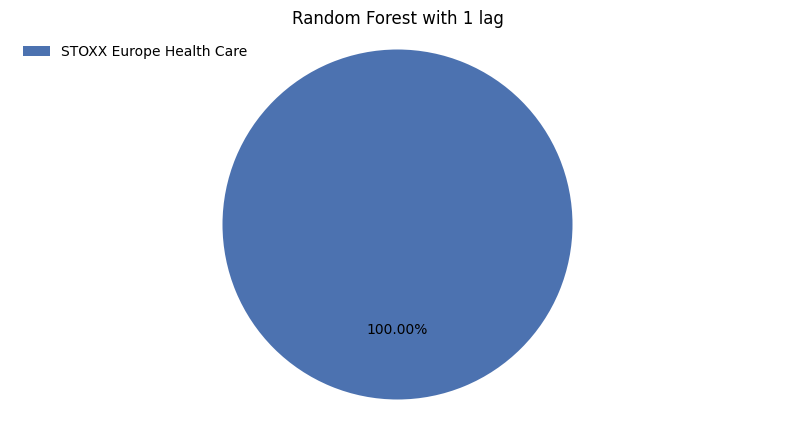

In [29]:
generate_pie_chart(weights_randomforest_1, 'Random Forest with 1 lag')

Weights:
                 STOXX Europe Banks  STOXX Europe Financials  STOXX Europe Auto & Parts  STOXX Europe Insurance  STOXX Europe Technology  STOXX Europe Utilities  STOXX Europe Chemicals  STOXX Europe Basic Resource  STOXX Europe Con & Mat  STOXX Europe Health Care  STOXX Europe Inds Gds & Svs  STOXX Europe Media  STOXX Europe Telecoms     Sum
Max Sharpe                   0.00%                    0.00%                      0.00%                   0.00%                    0.00%                   0.00%                   0.00%                        0.00%                   0.00%                   100.00%                        0.00%               0.00%                  0.00% 100.00%
Min Volatility              24.25%                   17.29%                      0.84%                  27.79%                    3.09%                   0.31%                   0.60%                        0.59%                   0.63%                    17.64%                        0.47%             

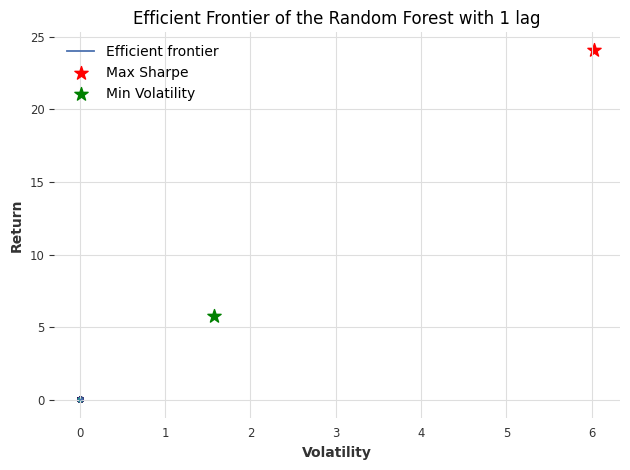

In [30]:
plot_efficient_frontier(mu_randomforest_1, S_randomforest_1, cum_returns_portfolio, 'Efficient Frontier of the Random Forest with 1 lag')

### Gradient Boosting Regressor

In [31]:
"""hyperparameter_gradient_boosting = {
    "lags": [1], #1, 316, 317, 335
    'model': [
        GradientBoostingRegressor(n_estimators=100,learning_rate=l, max_depth=m, random_state=0)   
        #for n in range(1, 100, 5)
        for m in range(1, 501, 10)
        for l in np.arange(0.1, 1, 0.2) 
        
    ]
}"""

'hyperparameter_gradient_boosting = {\n    "lags": [1], #1, 316, 317, 335\n    \'model\': [\n        GradientBoostingRegressor(n_estimators=100,learning_rate=l, max_depth=m, random_state=0)   \n        #for n in range(1, 100, 5)\n        for m in range(1, 501, 10)\n        for l in np.arange(0.1, 1, 0.2) \n        \n    ]\n}'

In [32]:
"""gradient_boosting_tune = RegressionModel(
    lags= hyperparameter_gradient_boosting['lags'][0],
    model=GradientBoostingRegressor(n_estimators=0, learning_rate=0, max_depth=0, random_state=0)
)"""

"gradient_boosting_tune = RegressionModel(\n    lags= hyperparameter_gradient_boosting['lags'][0],\n    model=GradientBoostingRegressor(n_estimators=0, learning_rate=0, max_depth=0, random_state=0)\n)"

In [33]:
"""tuning_gradient_boosting = gradient_boosting_tune.gridsearch(
    parameters= hyperparameter_gradient_boosting,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mse,
    n_jobs= -1,
    verbose= True
)"""

'tuning_gradient_boosting = gradient_boosting_tune.gridsearch(\n    parameters= hyperparameter_gradient_boosting,\n    series= train,\n    val_series= test,\n    start= 0.1,\n    metric= mse,\n    n_jobs= -1,\n    verbose= True\n)'

In [34]:
"""# print the best parameters
best_model, best_params = tuning_gradient_boosting[0], tuning_gradient_boosting[1]
best_model.model_params"""

'# print the best parameters\nbest_model, best_params = tuning_gradient_boosting[0], tuning_gradient_boosting[1]\nbest_model.model_params'

In [35]:
# gradient boosting regression model with 1 lag
gradient_boosting_model_1 = RegressionModel(lags=1, model=sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=31, learning_rate=0.3, random_state=0))
gradient_boosting_model_1.fit(train)
gradient_boosting_forecast_1 = gradient_boosting_model_1.predict(len(test))

# gradient boosting regression model with 316 lags
#gradient_boosting_model_316 = RegressionModel(lags=316, model=sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=400, learning_rate=0.5))
#gradient_boosting_model_316.fit(train)
#gradient_boosting_forecast_316 = gradient_boosting_model_316.predict(len(test))

# gradient boosting regression model with 317 lags
#gradient_boosting_model_317 = RegressionModel(lags=317, model=sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=400, learning_rate=0.5))
#gradient_boosting_model_317.fit(train)
#gradient_boosting_forecast_317 = gradient_boosting_model_317.predict(len(test))

# gradient boosting regression model with 335 lags
#gradient_boosting_model_335 = RegressionModel(lags=335, model=sklearn.ensemble.GradientBoostingRegressor(n_estimators=1000, max_depth=800, learning_rate=0.9))
#gradient_boosting_model_335.fit(train)
#gradient_boosting_forecast_335 = gradient_boosting_model_335.predict(len(test))

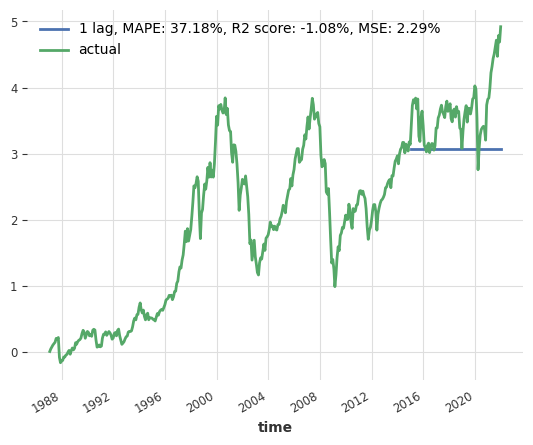

In [36]:
# plot the gradient boosting forecast with 1, 316, 317 and 335 lags and label with MAPE rounded to 2 decimals and R2 score rounded to 2 decimals and MSE rounded to 2 decimals
gradient_boosting_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, gradient_boosting_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, gradient_boosting_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, gradient_boosting_forecast_1), 2)) + '%')
#gradient_boosting_forecast_316['STOXX Europe 600'].plot(label='316 lags, MAPE: ' + str(round(mape(test, gradient_boosting_forecast_316), 2)) + '%, R2 score: ' + str(round(r2_score(test, gradient_boosting_forecast_316), 2)) + '%, MSE: ' + str(round(mse(test, gradient_boosting_forecast_316), 2)) + '%')
#gradient_boosting_forecast_317['STOXX Europe 600'].plot(label='317 lags, MAPE: ' + str(round(mape(test, gradient_boosting_forecast_317), 2)) + '%, R2 score: ' + str(round(r2_score(test, gradient_boosting_forecast_317), 2)) + '%, MSE: ' + str(round(mse(test, gradient_boosting_forecast_317), 2)) + '%')
#gradient_boosting_forecast_335['STOXX Europe 600'].plot(label='335 lags, MAPE: ' + str(round(mape(test, gradient_boosting_forecast_335), 2)) + '%, R2 score: ' + str(round(r2_score(test, gradient_boosting_forecast_335), 2)) + '%, MSE: ' + str(round(mse(test, gradient_boosting_forecast_335), 2)) + '%')

# rewrite to see only one line
cum_returns['STOXX Europe 600'].plot(label='actual')

In [37]:
# first gradient boosting model with 1 lag
hf1_gradient_boosting = gradient_boosting_model_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# first gradient boosting model with 316 lags
#hf316_gradient_boosting = gradient_boosting_model_316.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# first gradient boosting model with 317 lags
#hf317_gradient_boosting = gradient_boosting_model_317.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

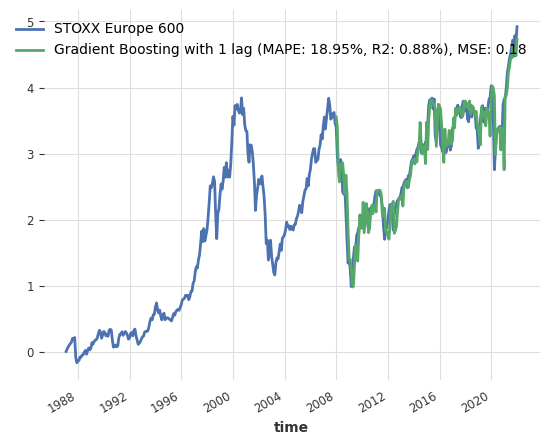

In [38]:
# compute historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
hf1_gradient_boosting['STOXX Europe 600'].plot(label='Gradient Boosting with 1 lag (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf1_gradient_boosting, cum_returns), r2_score(hf1_gradient_boosting, cum_returns), mse(hf1_gradient_boosting, cum_returns)))
#hf316_gradient_boosting['STOXX Europe 600'].plot(label='Gradient Boosting with 316 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf316_gradient_boosting, cum_returns), r2_score(hf316_gradient_boosting, cum_returns), mse(hf316_gradient_boosting, cum_returns)))
#hf317_gradient_boosting['STOXX Europe 600'].plot(label='Gradient Boosting with 317 lags (MAPE: {:.2f}%, R2: {:.2f}%), MSE: {:.2f}'.format(mape(hf317_gradient_boosting, cum_returns), r2_score(hf317_gradient_boosting, cum_returns), mse(hf317_gradient_boosting, cum_returns)))

#### Portfolio

In [39]:
# change the type of the gradient boosting forecast to a dataframe
gradient_boosting_forecast_1 = gradient_boosting_forecast_1.pd_dataframe()

In [40]:
# perform mean-variance optimization on the gradient boosting forecast
mu_gb_1 = expected_returns.mean_historical_return(gradient_boosting_forecast_1)
S_gb_1 = risk_models.sample_cov(gradient_boosting_forecast_1)

In [41]:
# optimize for maximal Sharpe ratio
ef_gb_1 = EfficientFrontier(mu_gb_1, S_gb_1)
ef_gb_1.add_constraint(lambda w: w[0] == 0)
weights_gb_1 = ef_gb_1.max_sharpe(risk_free_rate=0.02)

In [42]:
# compute the returns of the gradient boosting portfolio
gb_returns_1 = (cum_returns_portfolio * weights_gb_1).sum(axis=1)

# add the gb returns to the dataframe
portfolio_returns['gradient_boosting_1'] = gb_returns_1

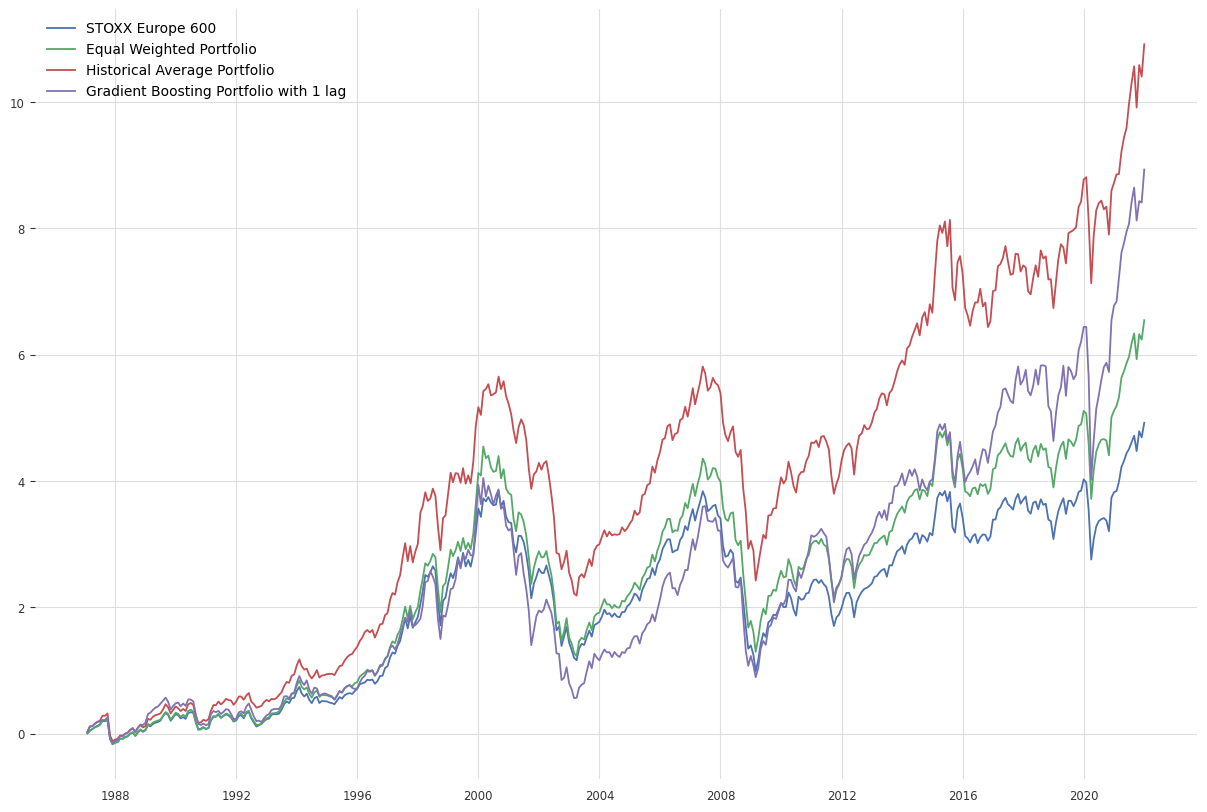

In [43]:
# plot the cumulative returns of the benchmark and the lasso regression portfolio
plt.figure(figsize=(15,10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], label='Equal Weighted Portfolio')
plt.plot(portfolio_returns['historical_average'], label='Historical Average Portfolio')
plt.plot(portfolio_returns['gradient_boosting_1'], label='Gradient Boosting Portfolio with 1 lag')
plt.legend()
plt.show();

In [44]:
# show the last value of each portfolio in percentage and round to 2 decimals
print('The last value of the equal weighted portfolio is: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('The last value of the historical average portfolio is: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('Volatility of the linear regression portfolio with 1 lag: ' + str(round(portfolio_returns['random_forest_1'].std(), 2)) + '%')
print('The last value of the gradient boosting portfolio with 1 lag is: ' + str(round(portfolio_returns['gradient_boosting_1'].iloc[-1], 2)) + '%')

The last value of the equal weighted portfolio is: 6.54%
The last value of the historical average portfolio is: 10.91%
Volatility of the linear regression portfolio with 1 lag: 6.03%
The last value of the gradient boosting portfolio with 1 lag is: 8.93%


In [45]:
# compute the volatility of each portfolio and print it
print('The volatility of the equal weighted portfolio is: ' + str(round(portfolio_returns['equal_weighted'].std(), 2)) + '%')
print('The volatility of the historical average portfolio is: ' + str(round(portfolio_returns['historical_average'].std(), 2)) + '%')
print('The volatility of the random forest portfolio with 1 lag is: ' + str(round(portfolio_returns['random_forest_1'].std(), 2)) + '%')
print('The volatility of the gradient boosting portfolio with 1 lag is: ' + str(round(portfolio_returns['gradient_boosting_1'].std(), 2)) + '%')

The volatility of the equal weighted portfolio is: 1.63%
The volatility of the historical average portfolio is: 2.67%
The volatility of the random forest portfolio with 1 lag is: 6.03%
The volatility of the gradient boosting portfolio with 1 lag is: 1.97%


The maximum portfolio return that possibly can be reached is 8.93%. Therefore, we only need to identify the one with the best performance measures.

In [46]:
# n_estimators=100, max_depth=300, learning_rate=0.5 - 19.79, 0.87, 0.19
# n_estimators=100, max_depth=31, learning_rate=0.3 - 18.95, 0.88, 0.18

# 8.93% - gradient_boosting_model_1 = RegressionModel(lags=1, model=sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=300, learning_rate=0.5)) # same with l=0.9

# 4.78% - gradient_boosting_model_1 = RegressionModel(lags=1, model=sklearn.ensemble.GradientBoostingRegressor(n_estimators=147, max_depth=300, learning_rate=0.5))

#### Plots Portfolio Analysis

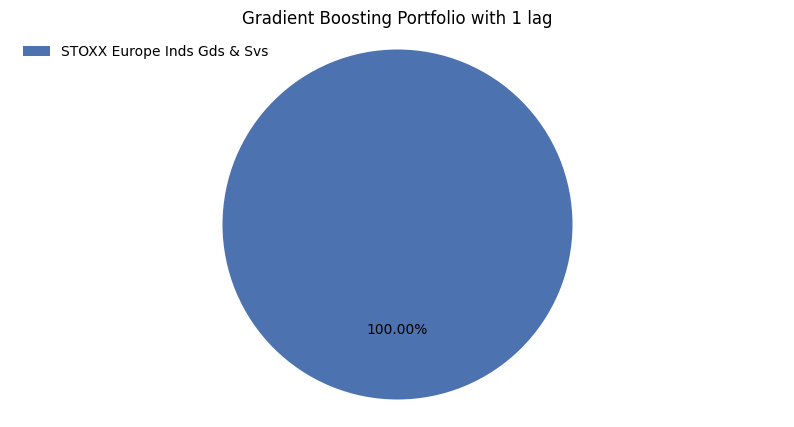

In [47]:
generate_pie_chart(weights_gb_1, 'Gradient Boosting Portfolio with 1 lag')

Weights:
                 STOXX Europe Banks  STOXX Europe Financials  STOXX Europe Insurance  STOXX Europe Technology  STOXX Europe Utilities  STOXX Europe Chemicals  STOXX Europe Basic Resource  STOXX Europe Con & Mat  STOXX Europe Health Care  STOXX Europe Inds Gds & Svs  STOXX Europe Media  STOXX Europe Telecoms     Sum
Max Sharpe                   0.00%                    0.00%                   0.00%                    0.00%                   0.00%                   0.00%                        0.00%                   0.00%                     0.00%                      100.00%               0.00%                  0.00% 100.00%
Min Volatility               9.28%                    2.35%                   9.28%                   10.03%                   3.29%                   9.37%                        9.28%                   9.48%                     5.21%                       12.01%              11.17%                  9.28% 100.00%

Performance:
                 Return  Vol

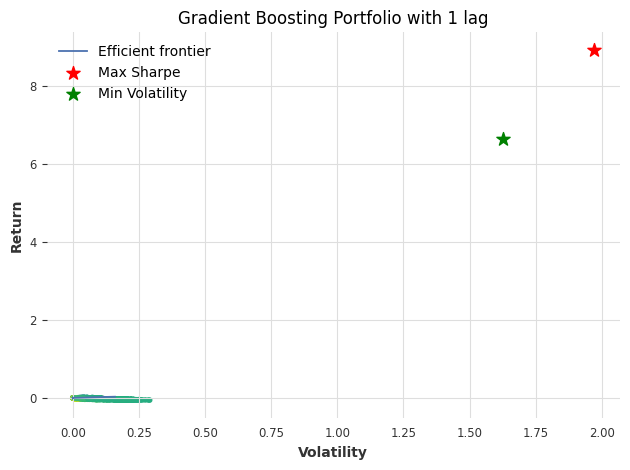

In [48]:
plot_efficient_frontier(mu_gb_1, S_gb_1, cum_returns_portfolio, 'Gradient Boosting Portfolio with 1 lag')

### Ada Boosting Regressor

In [49]:
"""hyperparameter_ada_boosting = {
    "lags": [1],
    'model': [
        sklearn.ensemble.AdaBoostRegressor(n_estimators=n, learning_rate=0.5, loss=x, random_state=0) 
        for n in np.arange(1, 500, 25)
        for l in np.arange(0.1, 1, 0.2)
        for x in ['linear', 'square', 'exponential']
    ]
}"""

'hyperparameter_ada_boosting = {\n    "lags": [1],\n    \'model\': [\n        sklearn.ensemble.AdaBoostRegressor(n_estimators=n, learning_rate=0.5, loss=x, random_state=0) \n        for n in np.arange(1, 500, 25)\n        for l in np.arange(0.1, 1, 0.2)\n        for x in [\'linear\', \'square\', \'exponential\']\n    ]\n}'

In [50]:
"""ada_boosting_tune = RegressionModel(
    lags= hyperparameter_ada_boosting['lags'][0],
    model=sklearn.ensemble.AdaBoostRegressor(n_estimators=0, random_state=0)
)"""

"ada_boosting_tune = RegressionModel(\n    lags= hyperparameter_ada_boosting['lags'][0],\n    model=sklearn.ensemble.AdaBoostRegressor(n_estimators=0, random_state=0)\n)"

In [51]:
"""tuning_ada_boosting = ada_boosting_tune.gridsearch(
    parameters= hyperparameter_ada_boosting,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)"""

'tuning_ada_boosting = ada_boosting_tune.gridsearch(\n    parameters= hyperparameter_ada_boosting,\n    series= train,\n    val_series= test,\n    start= 0.1,\n    metric= mape,\n    n_jobs= -1,\n    verbose= True\n)'

In [52]:
"""# print the best model parameters
best_model, best_params = tuning_ada_boosting[0], tuning_ada_boosting[1]
best_model.model_params"""

'# print the best model parameters\nbest_model, best_params = tuning_ada_boosting[0], tuning_ada_boosting[1]\nbest_model.model_params'

In [53]:
# first ada boosting model with 1 lag
ada_boosting_1 = RegressionModel(lags= 1, model=sklearn.ensemble.AdaBoostRegressor(n_estimators=50, learning_rate=0.3, random_state=0, loss='exponential'))
ada_boosting_1.fit(train)
ada_boosting_forecast_1 = ada_boosting_1.predict(len(test))

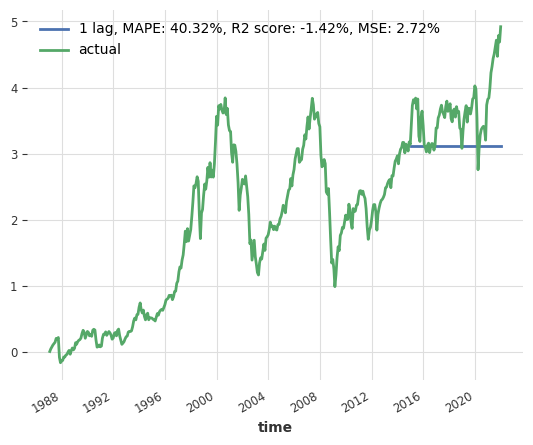

In [54]:
# plot the forecast of the ada boosting model with 1 lag
ada_boosting_forecast_1['STOXX Europe 600'].plot(label='1 lag, MAPE: ' + str(round(mape(test, ada_boosting_forecast_1), 2)) + '%, R2 score: ' + str(round(r2_score(test, ada_boosting_forecast_1), 2)) + '%, MSE: ' + str(round(mse(test, ada_boosting_forecast_1), 2)) + '%')
# plot cum returns
cum_returns['STOXX Europe 600'].plot(label='actual')

In [55]:
# first ada boosting model with 1 lag
hf1_ada_boosting = ada_boosting_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

  0%|          | 0/169 [00:00<?, ?it/s]

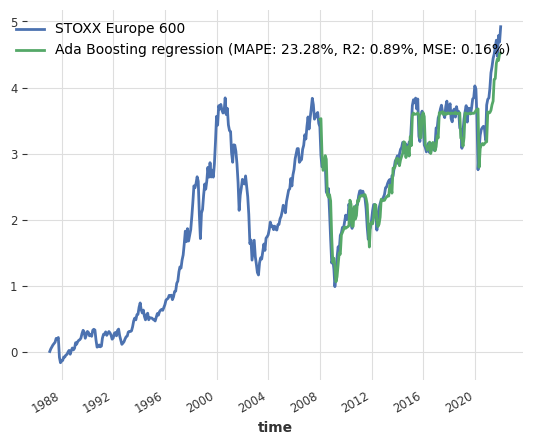

In [56]:
# compute the historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
# hf1 with mape, mse and r2
hf1_ada_boosting['STOXX Europe 600'].plot(label='Ada Boosting regression (MAPE: {:.2f}%, R2: {:.2f}%, MSE: {:.2f}%)'.format(mape(hf1_ada_boosting, cum_returns), r2_score(hf1_ada_boosting, cum_returns), mse(hf1_ada_boosting, cum_returns)))
plt.legend()
plt.show();

#### Portfolio

In [57]:
# change the type of the ada boosting forecast to a dataframe
ada_boosting_forecast = ada_boosting_forecast_1.pd_dataframe()

In [58]:
# perform mean-variance optimization on the ada boosting forecast
mu_ada_boosting = expected_returns.mean_historical_return(ada_boosting_forecast)
S_ada_boosting = risk_models.sample_cov(ada_boosting_forecast)

In [59]:
# optimize for maximal Sharpe ratio
ef_ada_boosting = EfficientFrontier(mu_ada_boosting, S_ada_boosting)
ef_ada_boosting.add_constraint(lambda w: w[0] == 0)
weights_ada_boosting = ef_ada_boosting.max_sharpe(risk_free_rate=0.02)

In [60]:
# compute the returns of the ada boosting portfolio
ada_boosting_returns = (cum_returns_portfolio * weights_ada_boosting).sum(axis=1)

# add the ada boosting returns to the dataframe
portfolio_returns['ada_boosting'] = ada_boosting_returns

In [61]:
# show the last value of each portfolio and round it to 2 decimals
print('Last value of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2)) + '%')
print('Last value of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].iloc[-1], 2)) + '%')
print('Last value of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].iloc[-1], 2)) + '%')
print('The last value of the gradient boosting portfolio with 1 lag is: ' + str(round(portfolio_returns['gradient_boosting_1'].iloc[-1], 2)) + '%')
print('Last value of the ada boosting portfolio: ' + str(round(portfolio_returns['ada_boosting'].iloc[-1], 2)) + '%')

Last value of the STOXX Europe 600: 4.92%
Last value of the equal weighted portfolio: 6.54%
Last value of the historical average portfolio: 10.91%
The last value of the gradient boosting portfolio with 1 lag is: 8.93%
Last value of the ada boosting portfolio: 7.35%


In [62]:
# compute the volatility of each portfolio
print('Volatility of the STOXX Europe 600: ' + str(round(cum_returns_portfolio['STOXX Europe 600'].std(), 2)) + '%')
print('Volatility of the equal weighted portfolio: ' + str(round(portfolio_returns['equal_weighted'].std(), 2)) + '%')
print('Volatility of the historical average portfolio: ' + str(round(portfolio_returns['historical_average'].std(), 2)) + '%')
print('Volatility of the gradient boosting portfolio with 1 lag: ' + str(round(portfolio_returns['gradient_boosting_1'].std(), 2)) + '%')
print('Volatility of the ada boosting portfolio: ' + str(round(portfolio_returns['ada_boosting'].std(), 2)) + '%')

Volatility of the STOXX Europe 600: 1.31%
Volatility of the equal weighted portfolio: 1.63%
Volatility of the historical average portfolio: 2.67%
Volatility of the gradient boosting portfolio with 1 lag: 1.97%
Volatility of the ada boosting portfolio: 2.36%


In [63]:
# n_estimators=50, learning_rate=0.5, loss='exponential' 
# 29.92; 0.90; 0.16

# n_estimators=176, learning_rate=0.5, loss='exponential'
# 21,7; 0.9; 0.16

# n_estimators=50, learning_rate=0.3, random_state=0, loss='exponential'
# 23.28; 0.89; 0.16

#### Plots Portfolio Analysis

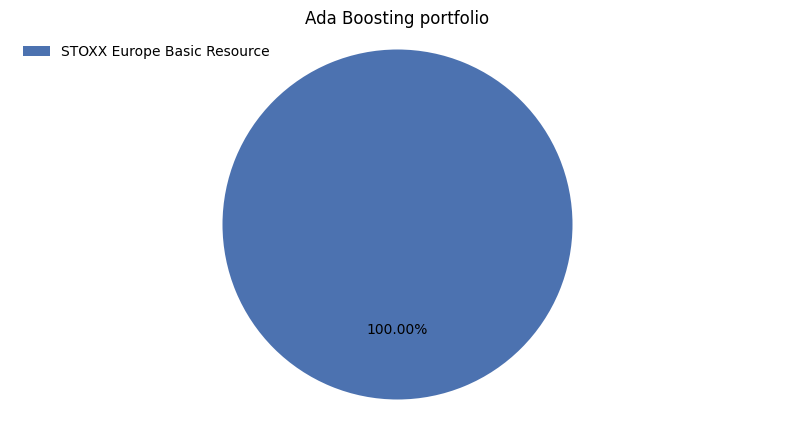

In [64]:
generate_pie_chart(weights_ada_boosting, 'Ada Boosting portfolio')

Weights:
                 STOXX Europe Banks  STOXX Europe Financials  STOXX Europe Utilities  STOXX Europe Chemicals  STOXX Europe Basic Resource  STOXX Europe Con & Mat  STOXX Europe Health Care  STOXX Europe Inds Gds & Svs  STOXX Europe Telecoms     Sum
Max Sharpe                   0.00%                    0.00%                   0.00%                   0.00%                      100.00%                   0.00%                     0.00%                        0.00%                  0.00% 100.00%
Min Volatility               9.69%                    9.41%                  10.20%                  11.42%                       14.46%                  11.29%                    10.41%                       11.29%                 11.82% 100.00%

Performance:
                 Return  Volatility
Max Sharpe       7.35%       2.36%
Min Volatility   7.83%       1.96%


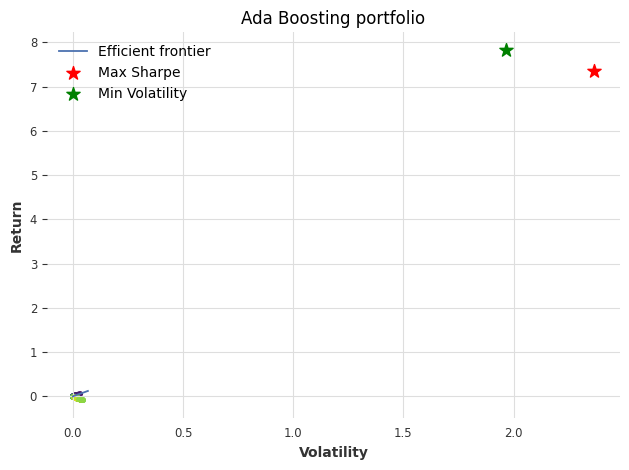

In [65]:
plot_efficient_frontier(mu_ada_boosting, S_ada_boosting, cum_returns_portfolio, 'Ada Boosting portfolio')

### Extremely randomized trees

In [66]:
"""hyperparameter_extra_trees = {
    "lags": [1],
    'model': [
        ExtraTreesRegressor(n_estimators=n, max_depth = 5, min_samples_split=15, random_state=0) 
        for n in np.arange(50, 200, 1)
        #for m in np.arange(1, 500, 5)
        #for s in np.arange(2, 20, 2)
        ]
}"""

'hyperparameter_extra_trees = {\n    "lags": [1],\n    \'model\': [\n        ExtraTreesRegressor(n_estimators=n, max_depth = 5, min_samples_split=15, random_state=0) \n        for n in np.arange(50, 200, 1)\n        #for m in np.arange(1, 500, 5)\n        #for s in np.arange(2, 20, 2)\n        ]\n}'

In [67]:
"""extra_trees_tune = RegressionModel(
    lags= hyperparameter_ada_boosting['lags'][0],
    model=ExtraTreesRegressor(n_estimators=0,  random_state=0)
)"""

"extra_trees_tune = RegressionModel(\n    lags= hyperparameter_ada_boosting['lags'][0],\n    model=ExtraTreesRegressor(n_estimators=0,  random_state=0)\n)"

In [68]:
"""tuning_extra_trees = extra_trees_tune.gridsearch(
    parameters= hyperparameter_extra_trees,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)"""

'tuning_extra_trees = extra_trees_tune.gridsearch(\n    parameters= hyperparameter_extra_trees,\n    series= train,\n    val_series= test,\n    start= 0.1,\n    metric= mape,\n    n_jobs= -1,\n    verbose= True\n)'

In [69]:
"""# print the best model parameters
best_model, best_params = tuning_extra_trees[0], tuning_extra_trees[1]
best_model.model_params"""

'# print the best model parameters\nbest_model, best_params = tuning_extra_trees[0], tuning_extra_trees[1]\nbest_model.model_params'

In [70]:
# extra trees model with 1 lag
extra_trees_1 = RegressionModel(lags= 1, model=ExtraTreesRegressor(n_estimators=62, max_depth= 5, min_samples_split= 15, random_state=0))
extra_trees_1.fit(train)
extra_trees_forecast_1 = extra_trees_1.predict(len(test))

  0%|          | 0/169 [00:00<?, ?it/s]

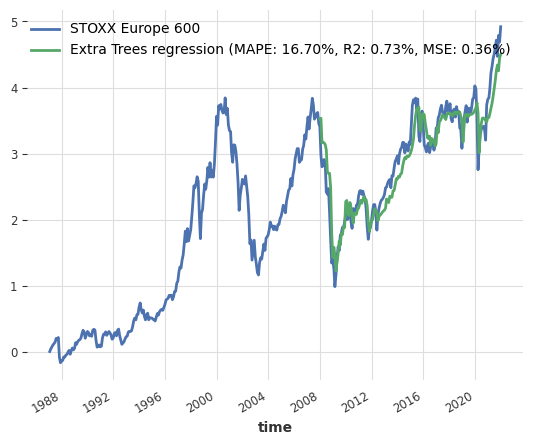

In [71]:
# historical forecasts of the extra trees model with 1 lag
hf1_extra_trees = extra_trees_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# compute the historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
# hf1 with mape, mse and r2
hf1_extra_trees['STOXX Europe 600'].plot(label='Extra Trees regression (MAPE: {:.2f}%, R2: {:.2f}%, MSE: {:.2f}%)'.format(mape(hf1_extra_trees, cum_returns), r2_score(hf1_extra_trees, cum_returns), mse(hf1_extra_trees, cum_returns)))
plt.legend()
plt.show();

#### Portfolio

In [72]:
# change the type of the extra trees forecast to a dataframe
extra_trees_forecast = extra_trees_forecast_1.pd_dataframe()

In [73]:
# perform mean-variance optimization on the extra trees forecast
mu_extra_trees = expected_returns.mean_historical_return(extra_trees_forecast)
S_extra_trees = risk_models.sample_cov(extra_trees_forecast)

In [74]:
# optimize for maximal Sharpe ratio
ef_extra_trees = EfficientFrontier(mu_extra_trees, S_extra_trees)
ef_extra_trees.add_constraint(lambda w: w[0] == 0)
weights_extra_trees = ef_extra_trees.max_sharpe()

In [75]:
# compute the returns of the extra trees portfolio
extra_trees_returns = (cum_returns_portfolio * weights_extra_trees).sum(axis=1)

# add the extra trees returns to the dataframe
portfolio_returns['extra_trees'] = extra_trees_returns

In [76]:
# show the last value of extra tree portfolio and round it to 2 decimals
print('Last value of the extra trees portfolio: ' + str(round(portfolio_returns['extra_trees'].iloc[-1], 2)) + '%')
print('The volatility of the extra trees portfolio is: ' + str(round(portfolio_returns['extra_trees'].std(), 2)) + '%')

Last value of the extra trees portfolio: 13.42%
The volatility of the extra trees portfolio is: 3.37%


#### Plots Portfolio Analysis

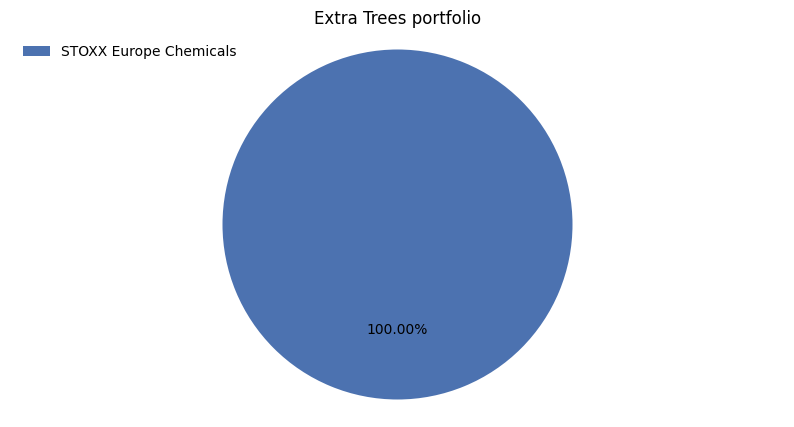

In [77]:
# generate pie chart
generate_pie_chart(weights_extra_trees, 'Extra Trees portfolio')

Weights:
                 STOXX Europe Banks  STOXX Europe Financials  STOXX Europe Auto & Parts  STOXX Europe Insurance  STOXX Europe Technology  STOXX Europe Utilities  STOXX Europe Chemicals  STOXX Europe Basic Resource  STOXX Europe Con & Mat  STOXX Europe Health Care  STOXX Europe Inds Gds & Svs  STOXX Europe Media  STOXX Europe Telecoms     Sum
Max Sharpe                   0.00%                    0.00%                      0.00%                   0.00%                    0.00%                   0.00%                 100.00%                        0.00%                   0.00%                     0.00%                        0.00%               0.00%                  0.00% 100.00%
Min Volatility               4.23%                    3.89%                     10.96%                   2.62%                    6.19%                   4.25%                  10.97%                       12.57%                   9.90%                     7.12%                       13.09%             

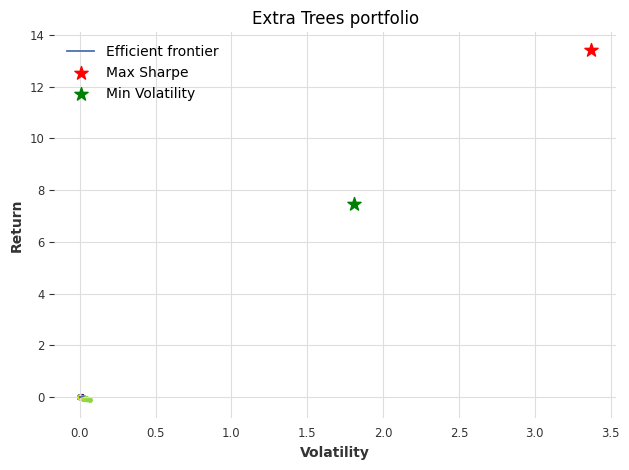

In [78]:
# plot efficient frontier
plot_efficient_frontier(mu_extra_trees, S_extra_trees, cum_returns_portfolio, 'Extra Trees portfolio')

In [79]:
# 13.42% - n_estimators=62, max_depth= 5, min_samples_split= 15
# 16.70; 0.73; 0.36

# 7.35% - n_estimators=50, max_depth= 5
# 16.08; 0.77; 0.32

# 3.06 - n_estimators=26, max_depth= 26
# 12.21; 0.88; 0.16

# 0.41% - n_estimators=100, max_depth= 26, min_samples_split= 6
# 12.30; 0.87; 0.18

### Epsilon Support Vector Machine (SVM)

In [80]:
# epsilon svm model with 1 lag
epsilon_svm_1 = RegressionModel(lags= 1, model=sklearn.svm.SVR(kernel='rbf', C=2, gamma=0.094, epsilon=0.069))
epsilon_svm_1.fit(train)
epsilon_svm_forecast_1 = epsilon_svm_1.predict(len(test))

  0%|          | 0/169 [00:00<?, ?it/s]

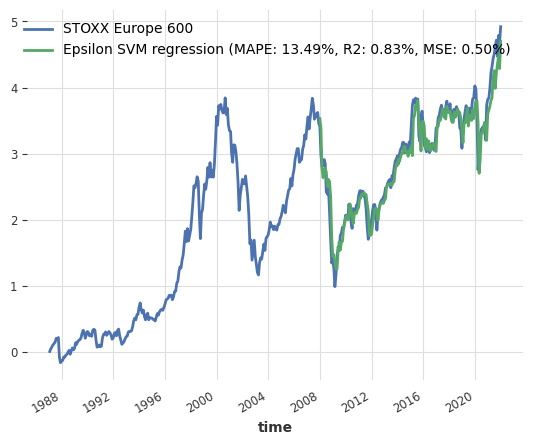

In [81]:
# historical forecasts of the epsilon svm model with 1 lag
hf1_epsilon_svm = epsilon_svm_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# compute the historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
# hf1 with mape, mse and r2
hf1_epsilon_svm['STOXX Europe 600'].plot(label='Epsilon SVM regression (MAPE: {:.2f}%, R2: {:.2f}%, MSE: {:.2f}%)'.format(mape(hf1_epsilon_svm, cum_returns), r2_score(hf1_epsilon_svm, cum_returns), mse(hf1_epsilon_svm, cum_returns)))
plt.legend()
plt.show();

#### Portfolio

In [82]:
# change the type of the epsilon svm forecast to a dataframe
epsilon_svm_forecast = epsilon_svm_forecast_1.pd_dataframe()

In [83]:
# perform mean-variance optimization on the epsilon svm forecast
mu_epsilon_svm = expected_returns.mean_historical_return(epsilon_svm_forecast)
S_epsilon_svm = risk_models.sample_cov(epsilon_svm_forecast)

In [84]:
# optimize for maximal Sharpe ratio
ef_epsilon_svm = EfficientFrontier(mu_epsilon_svm, S_epsilon_svm)
ef_epsilon_svm.add_constraint(lambda w: w[0] == 0)
weights_epsilon_svm = ef_epsilon_svm.max_sharpe(risk_free_rate=0.02)

In [85]:
# compute the returns of the epsilon svm portfolio
epsilon_svm_returns = (cum_returns_portfolio * weights_epsilon_svm).sum(axis=1)

# add the epsilon svm returns to the dataframe
portfolio_returns['epsilon_svm'] = epsilon_svm_returns

In [86]:
# show the last value of epsilon svm portfolio and round it to 2 decimals
print('Last value of the epsilon svm portfolio: ' + str(round(portfolio_returns['epsilon_svm'].iloc[-1], 2)) + '%')
print('The volatility of the epsilon svm portfolio is: ' + str(round(portfolio_returns['epsilon_svm'].std(), 2)) + '%')

Last value of the epsilon svm portfolio: 20.64%
The volatility of the epsilon svm portfolio is: 5.12%


In [87]:
# 20.64% - kernel='rbf', C=2, gamma=0.094, epsilon=0.069
# 13.49; 0.83; 0.50

# 20.16% - kernel='rbf', C=2, gamma=0.09, epsilon=0.07
# 13.49; 0.83; 0.49

# 19.58% - kernel='rbf', C=2, gamma=0.09, epsilon= 0.06
# 13.23; 0.84; 0.49

# 17.76% - kernel='rbf', C=2, gamma=0.09, epsilon= 0.05
# 15.15; 0.84; 0.49

# 17.29% - kernel='rbf', C=2, gamma=0.1, epsilon=0.04
# 14.78; 0.84; 0.49

# 16.79% - kernel='rbf', C=2, gamma=0.09, epsilon=.1
# 13.53; 0.83; 0.49

# 7.65% - kernel='rbf', C=1, gamma=0.1, epsilon=.1
# 15.54; 0.71; 0.93

# 5.04% - kernel='rbf', C=100, gamma=0.1, epsilon=.1
# 14.54; 0.85; 0.24%



#### Plots Portfolio Analysis

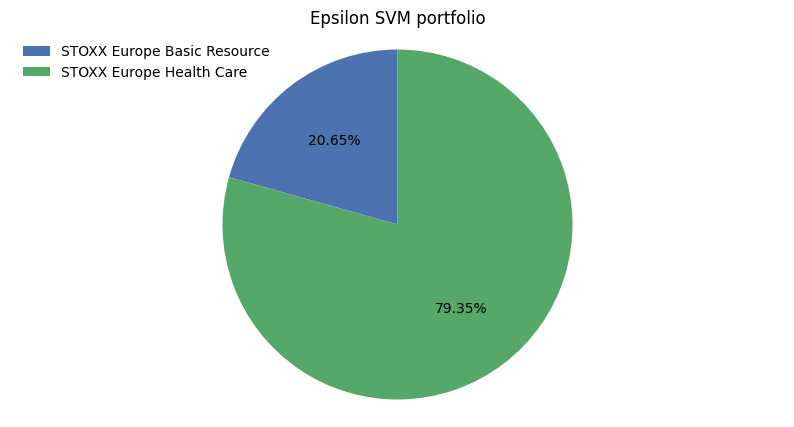

In [88]:
# generate pie chart
generate_pie_chart(weights_epsilon_svm, 'Epsilon SVM portfolio')

Weights:
                 STOXX Europe Banks  STOXX Europe Financials  STOXX Europe Technology  STOXX Europe Basic Resource  STOXX Europe Health Care     Sum
Max Sharpe                   0.00%                    0.00%                    0.00%                       20.65%                    79.35% 100.00%
Min Volatility              31.21%                   15.52%                    0.63%                        0.24%                    52.39% 100.00%

Performance:
                 Return  Volatility
Max Sharpe      20.64%       5.12%
Min Volatility  12.99%       3.30%


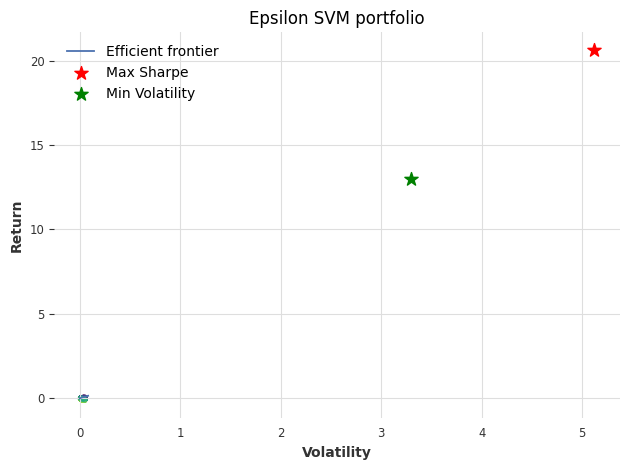

In [89]:
# plot efficient frontier
plot_efficient_frontier(mu_epsilon_svm, S_epsilon_svm, cum_returns_portfolio, 'Epsilon SVM portfolio')

### Nu Support Vector Machine (SVM)

In [90]:
# nu svm model with 1 lag
nu_svm_1 = RegressionModel(lags= 1, model=sklearn.svm.NuSVR(kernel='rbf', C=13, gamma=0.04, nu=0.55))
nu_svm_1.fit(train)
nu_svm_forecast_1 = nu_svm_1.predict(len(test))

  0%|          | 0/169 [00:00<?, ?it/s]

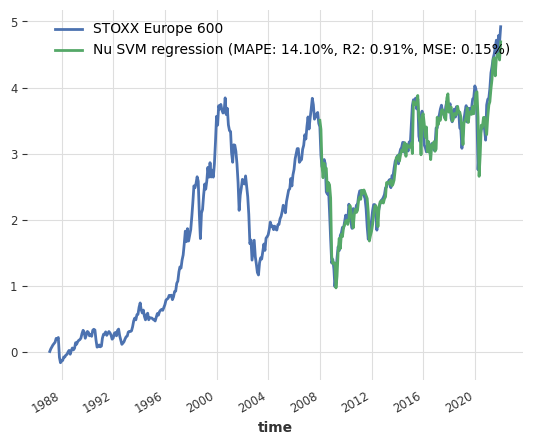

In [91]:
# historical forecasts of the nu svm model with 1 lag
hf1_nu_svm = nu_svm_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# compute the historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
# hf1 with mape, mse and r2
hf1_nu_svm['STOXX Europe 600'].plot(label='Nu SVM regression (MAPE: {:.2f}%, R2: {:.2f}%, MSE: {:.2f}%)'.format(mape(hf1_nu_svm, cum_returns), r2_score(hf1_nu_svm, cum_returns), mse(hf1_nu_svm, cum_returns)))
plt.legend()
plt.show();

#### Portfolio

In [92]:
# change the type of the nu svm forecast to a dataframe
nu_svm_forecast = nu_svm_forecast_1.pd_dataframe()

In [93]:
# perform mean-variance optimization on the nu svm forecast
mu_nu_svm = expected_returns.mean_historical_return(nu_svm_forecast)
S_nu_svm = risk_models.sample_cov(nu_svm_forecast)

In [94]:
# optimize for maximal Sharpe ratio
ef_nu_svm = EfficientFrontier(mu_nu_svm, S_nu_svm)
ef_nu_svm.add_constraint(lambda w: w[0] == 0)
weights_nu_svm = ef_nu_svm.max_sharpe(risk_free_rate=0.02)

In [95]:
# compute the returns of the nu svm portfolio
nu_svm_returns = (cum_returns_portfolio * weights_nu_svm).sum(axis=1)

# add the nu svm returns to the dataframe
portfolio_returns['nu_svm'] = nu_svm_returns

In [96]:
# show the last value of nu svm portfolio and round it to 2 decimals
print('Last value of the nu svm portfolio: ' + str(round(portfolio_returns['nu_svm'].iloc[-1], 2)) + '%')
print('The volatility of the nu svm portfolio is: ' + str(round(portfolio_returns['nu_svm'].std(), 2)) + '%')

Last value of the nu svm portfolio: 18.02%
The volatility of the nu svm portfolio is: 4.45%


In [97]:
# 18.02% - kernel='rbf', C=13, gamma=0.04, nu=0.55
# 14.10; 0.91; 0.15

# 12.33% - kernel='rbf', C=20, gamma=0.02, nu=0.55
# 12.51; 0.92; 0.13

#### Plots Portfolio Analysis

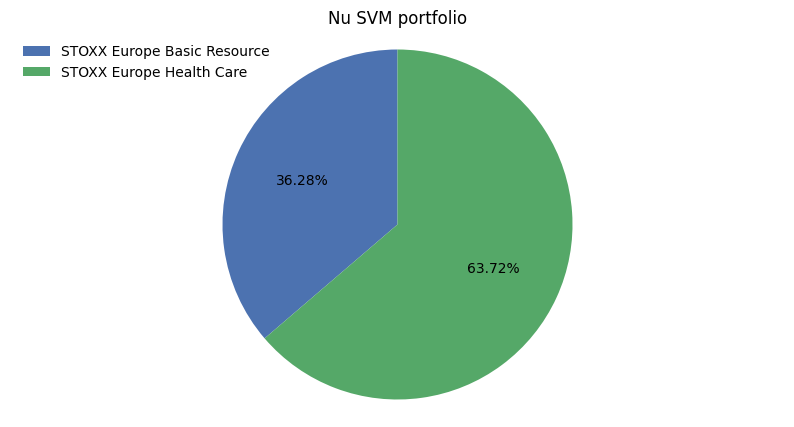

In [98]:
# generate pie chart
generate_pie_chart(weights_nu_svm, 'Nu SVM portfolio')

Weights:
                 STOXX Europe Banks  STOXX Europe Insurance  STOXX Europe Technology  STOXX Europe Basic Resource  STOXX Europe Health Care     Sum
Max Sharpe                   0.00%                   0.00%                    0.00%                       36.28%                    63.72% 100.00%
Min Volatility              16.42%                   1.51%                    9.30%                       15.00%                    57.76% 100.00%

Performance:
                 Return  Volatility
Max Sharpe      18.02%       4.45%
Min Volatility  15.69%       3.88%


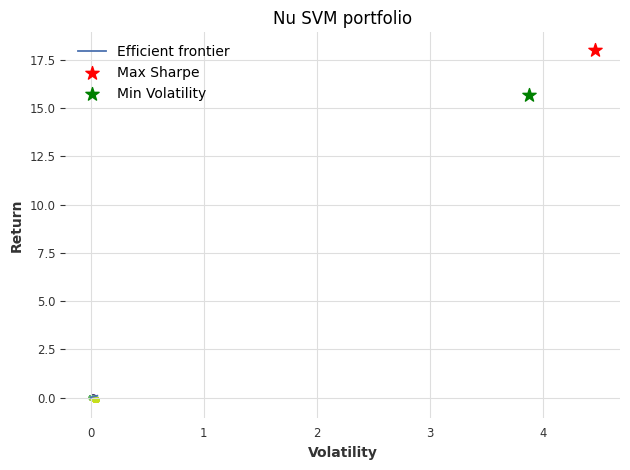

In [99]:
# plot efficient frontier
plot_efficient_frontier(mu_nu_svm, S_nu_svm, cum_returns_portfolio, 'Nu SVM portfolio')

### Multilayer perceptron, one hidden layer (MLP1)

geometric pyramid rule by Masters (1993) 

- Not working accordingly. Therefore, not used so far.

In [100]:
"""# mlp1 model with 1 lag
mlp1_1 = RegressionModel(lags= 1, model=sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(10,), activation='relu', random_state= 0))
mlp1_1.fit(train)
mlp1_forecast_1 = mlp1_1.predict(len(test))
# historical forecasts of the mlp1 model with 1 lag
hf1_mlp1 = mlp1_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)

# compute the historical forecasts that would have been obtained by this model
cum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')
# hf1 with mape, mse and r2
hf1_mlp1['STOXX Europe 600'].plot(label='MLP1 regression (MAPE: {:.2f}%, R2: {:.2f}%, MSE: {:.2f}%)'.format(mape(hf1_mlp1, cum_returns), r2_score(hf1_mlp1, cum_returns), mse(hf1_mlp1, cum_returns)))
plt.legend()
plt.show();
# change the type of the mlp1 forecast to a dataframe
mlp1_forecast = mlp1_forecast_1.pd_dataframe()
# perform mean-variance optimization on the mlp1 forecast
mu_mlp1 = expected_returns.mean_historical_return(mlp1_forecast)
S_mlp1 = risk_models.sample_cov(mlp1_forecast)
# optimize for maximal Sharpe ratio
ef_mlp1 = EfficientFrontier(mu_mlp1, S_mlp1)
ef_mlp1.add_constraint(lambda w: w[0] == 0)
weights_mlp1 = ef_mlp1.max_sharpe(risk_free_rate=0.02)
# compute the returns of the mlp1 portfolio
mlp1_returns = (cum_returns_portfolio * weights_mlp1).sum(axis=1)

# add the mlp1 returns to the dataframe
portfolio_returns['mlp1'] = mlp1_returns
# show the last value of mlp1 portfolio and round it to 2 decimals
print('Last value of the mlp1 portfolio: ' + str(round(portfolio_returns['mlp1'].iloc[-1], 2)) + '%')
print('The volatility of the mlp1 portfolio is: ' + str(round(portfolio_returns['mlp1'].std(), 2)) + '%')"""

"# mlp1 model with 1 lag\nmlp1_1 = RegressionModel(lags= 1, model=sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(10,), activation='relu', random_state= 0))\nmlp1_1.fit(train)\nmlp1_forecast_1 = mlp1_1.predict(len(test))\n# historical forecasts of the mlp1 model with 1 lag\nhf1_mlp1 = mlp1_1.historical_forecasts(series= cum_returns, start= 0.6, forecast_horizon= 1, verbose= True)\n\n# compute the historical forecasts that would have been obtained by this model\ncum_returns['STOXX Europe 600'].plot(label='STOXX Europe 600')\n# hf1 with mape, mse and r2\nhf1_mlp1['STOXX Europe 600'].plot(label='MLP1 regression (MAPE: {:.2f}%, R2: {:.2f}%, MSE: {:.2f}%)'.format(mape(hf1_mlp1, cum_returns), r2_score(hf1_mlp1, cum_returns), mse(hf1_mlp1, cum_returns)))\nplt.legend()\nplt.show();\n# change the type of the mlp1 forecast to a dataframe\nmlp1_forecast = mlp1_forecast_1.pd_dataframe()\n# perform mean-variance optimization on the mlp1 forecast\nmu_mlp1 = expected_returns.mean_historical_r

In [48]:
# compute the number of inout nodes for the mlp1 model
input_nodes = len(train.columns) * 1
input_nodes

14

In [101]:
# 11.06 - hidden_layer_sizes=(11,), activation='relu', random_state= 0
# 77.47; 0.28; 1.47

# 7.63% - hidden_layer_sizes=(10,), activation='relu', random_state= 0
# 73.77; 0.62; 0.45

# 4.55% - hidden_layer_sizes=(9,), activation='relu', random_state= 0
# 21.44; 0.55; 0.34s

# Outcome Nonlinear ML Portfolio Building

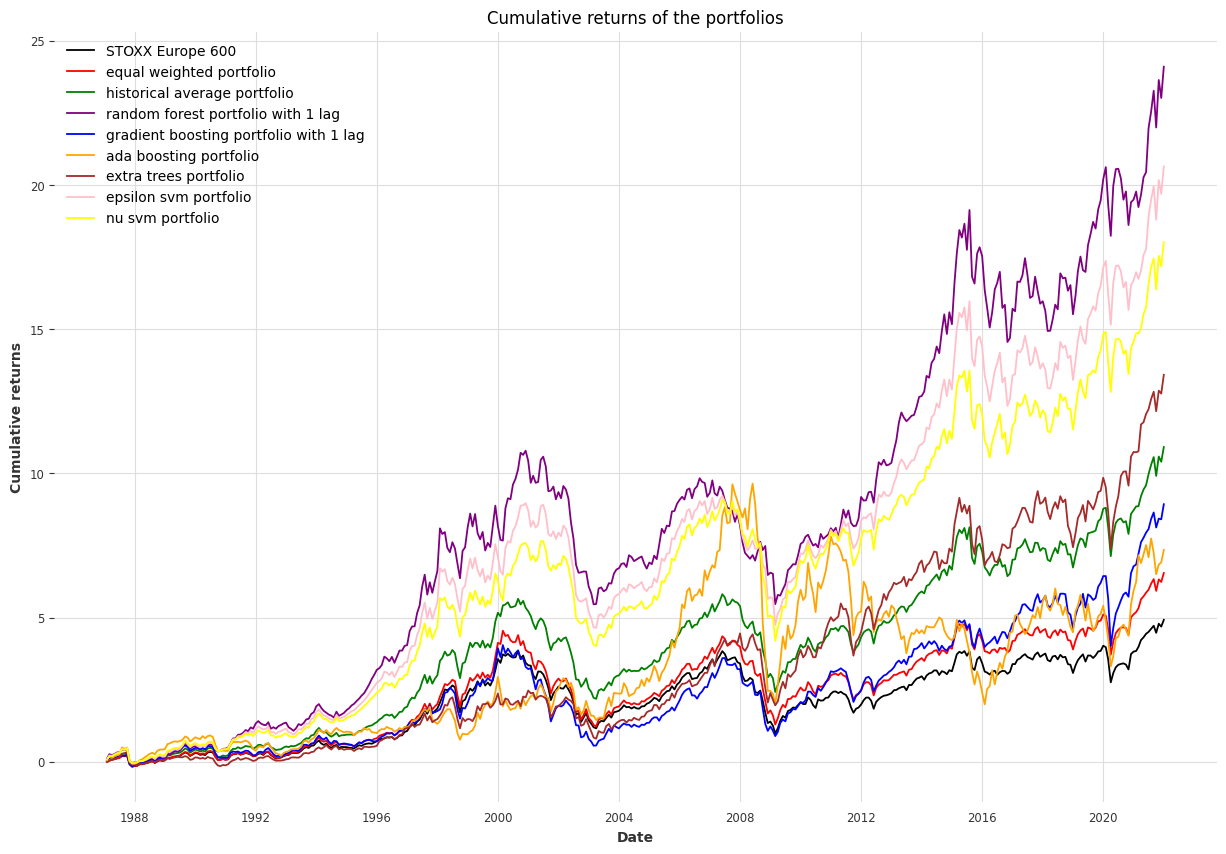

In [102]:
# plot all the cumulative returns
plt.figure(figsize=(15, 10))
plt.plot(cum_returns_portfolio['STOXX Europe 600'], label='STOXX Europe 600', color='black')
plt.plot(portfolio_returns['equal_weighted'], label='equal weighted portfolio', color='red')
plt.plot(portfolio_returns['historical_average'], label='historical average portfolio', color='green')
plt.plot(portfolio_returns['random_forest_1'], label='random forest portfolio with 1 lag', color='purple')
plt.plot(portfolio_returns['gradient_boosting_1'], label='gradient boosting portfolio with 1 lag', color='blue')
plt.plot(portfolio_returns['ada_boosting'], label='ada boosting portfolio', color='orange')
plt.plot(portfolio_returns['extra_trees'], label='extra trees portfolio', color='brown')
plt.plot(portfolio_returns['epsilon_svm'], label='epsilon svm portfolio', color='pink')
plt.plot(portfolio_returns['nu_svm'], label='nu svm portfolio', color='yellow')
plt.legend()
plt.title('Cumulative returns of the portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative returns')
plt.show();

In [103]:
# create a dictionary with the data
data = {
    'Portfolio': ['STOXX Europe 600', 'Equal Weighted', 'Historical Average', 'Random Forest', 'Gradient Boosting', 'Ada Boosting', 'Extra Trees', 'Epsilon SVM', 'Nu SVM'],
    'Return': [round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2), round(portfolio_returns['equal_weighted'].iloc[-1], 2), round(portfolio_returns['historical_average'].iloc[-1], 2), round(portfolio_returns['random_forest_1'].iloc[-1], 2), round(portfolio_returns['gradient_boosting_1'].iloc[-1], 2), round(portfolio_returns['ada_boosting'].iloc[-1], 2), round(portfolio_returns['extra_trees'].iloc[-1], 2), round(portfolio_returns['epsilon_svm'].iloc[-1], 2), round(portfolio_returns['nu_svm'].iloc[-1], 2)],
    'Volatility': [round(cum_returns_portfolio['STOXX Europe 600'].std(), 2), round(portfolio_returns['equal_weighted'].std(), 2), round(portfolio_returns['historical_average'].std(), 2), round(portfolio_returns['random_forest_1'].std(), 2), round(portfolio_returns['gradient_boosting_1'].std(), 2), round(portfolio_returns['ada_boosting'].std(), 2), round(portfolio_returns['extra_trees'].std(), 2), round(portfolio_returns['epsilon_svm'].std(), 2), round(portfolio_returns['nu_svm'].std(), 2)],
}

# create a dataframe from the dictionary
df = pd.DataFrame(data)

# divide the vlues by 100 to get percentages
df['Return'] = df['Return'].div(100)
df['Volatility'] = df['Volatility'].div(100)

# set the index to the portfolio names
df.set_index('Portfolio', inplace=True)

# format the dataframe to display the values as percentages
df.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
STOXX Europe 600,4.92%,1.31%
Equal Weighted,6.54%,1.63%
Historical Average,10.91%,2.67%
Random Forest,24.10%,6.03%
Gradient Boosting,8.93%,1.97%
Ada Boosting,7.35%,2.36%
Extra Trees,13.42%,3.37%
Epsilon SVM,20.64%,5.12%
Nu SVM,18.02%,4.45%


In [104]:
# print this customized table to latex including the percentage sign and multiply the values by 100
print(df.to_latex(float_format="%.2f", formatters={"Return": "{:.2%}".format, "Volatility": "{:.2%}".format}))

\begin{tabular}{lrr}
\toprule
{} & Return & Volatility \\
Portfolio          &        &            \\
\midrule
STOXX Europe 600   &  4.92\% &      1.31\% \\
Equal Weighted     &  6.54\% &      1.63\% \\
Historical Average & 10.91\% &      2.67\% \\
Random Forest      & 24.10\% &      6.03\% \\
Gradient Boosting  &  8.93\% &      1.97\% \\
Ada Boosting       &  7.35\% &      2.36\% \\
Extra Trees        & 13.42\% &      3.37\% \\
Epsilon SVM        & 20.64\% &      5.12\% \\
Nu SVM             & 18.02\% &      4.45\% \\
\bottomrule
\end{tabular}



In [105]:
# sort this table according to the return
df.sort_values(by=['Return'], inplace=True, ascending=False)

# display the table
df.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
Random Forest,24.10%,6.03%
Epsilon SVM,20.64%,5.12%
Nu SVM,18.02%,4.45%
Extra Trees,13.42%,3.37%
Historical Average,10.91%,2.67%
Gradient Boosting,8.93%,1.97%
Ada Boosting,7.35%,2.36%
Equal Weighted,6.54%,1.63%
STOXX Europe 600,4.92%,1.31%


In [106]:
# convert portfolio returns as pandas.core.Series to a darts.timeseries.TimeSeries
# save portfolio returns as a csv file

portfolio_returns.to_csv('data/portfolio_returns_nonlinearML.csv', index=True, header=True)

# get portfolio returns from csv file
portfolio_returns_timeseries = TimeSeries.from_csv('data/portfolio_returns_nonlinearML.csv', index_col=0, parse_dates=True)

In [109]:
# create a table that includes mape, mse and r2 for each portfolio
data2 = {
    'Portfolio': ['Random Forest', 'Gradient Boosting', 'Ada Boosting', 'Extra Trees', 'Epsilon SVM', 'Nu SVM'],
    'MAPE': [mape(hf1_random_forest, cum_returns),
                mape(hf1_gradient_boosting, cum_returns),
                mape(hf1_ada_boosting, cum_returns),
                mape(hf1_extra_trees, cum_returns),
                mape(hf1_epsilon_svm, cum_returns),
                mape(hf1_nu_svm, cum_returns)],
    'MSE': [mse(hf1_random_forest, cum_returns),
                mse(hf1_gradient_boosting, cum_returns),
                mse(hf1_ada_boosting, cum_returns),
                mse(hf1_extra_trees, cum_returns),
                mse(hf1_epsilon_svm, cum_returns),
                mse(hf1_nu_svm, cum_returns)],
    'R2 Score': [r2_score(hf1_random_forest, cum_returns),
                r2_score(hf1_gradient_boosting, cum_returns),
                r2_score(hf1_ada_boosting, cum_returns),
                r2_score(hf1_extra_trees, cum_returns),
                r2_score(hf1_epsilon_svm, cum_returns),
                r2_score(hf1_nu_svm, cum_returns)]
}
    

In [110]:
# create a dataframe from the dictionary
df2 = pd.DataFrame(data2)

# set the index to the portfolio names
df2.set_index('Portfolio', inplace=True)

# divide the vlues by 100 to get percentages
df2[['MAPE', 'MSE', 'R2 Score']] = df2[['MAPE', 'MSE', 'R2 Score']].div(100)

# format the dataframe to display the values as percentages
df2.style.format("{:.2%}", subset=['MAPE', 'MSE', 'R2 Score'])

,MAPE,MSE,R2 Score
Portfolio,,,
Random Forest,13.01%,0.20%,0.79%
Gradient Boosting,18.95%,0.18%,0.88%
Ada Boosting,23.28%,0.16%,0.89%
Extra Trees,16.70%,0.36%,0.73%
Epsilon SVM,13.49%,0.50%,0.83%
Nu SVM,14.10%,0.15%,0.91%


In [111]:
# print this customized table to latex including the percentage sign and multiply the values by 100
print(df2.to_latex(float_format="%.2f", formatters={"MAPE": "{:.2%}".format, "MSE": "{:.2%}".format, "R2": "{:.2%}".format}))

\begin{tabular}{lrrr}
\toprule
{} &   MAPE &   MSE &  R2 Score \\
Portfolio         &        &       &           \\
\midrule
Random Forest     & 13.01\% & 0.20\% &      0.01 \\
Gradient Boosting & 18.95\% & 0.18\% &      0.01 \\
Ada Boosting      & 23.28\% & 0.16\% &      0.01 \\
Extra Trees       & 16.70\% & 0.36\% &      0.01 \\
Epsilon SVM       & 13.49\% & 0.50\% &      0.01 \\
Nu SVM            & 14.10\% & 0.15\% &      0.01 \\
\bottomrule
\end{tabular}



In [112]:
# save the table as a csv file
df2.to_csv('data/evaluation_nonlinear.csv', index=True, header=True)